# Depresjon - custom features

This notebook aims to get better results than the `depresjon_eda_and_basic_reproduction` one, using alternative hand-crafted features and other algorithms.

## Libraries

In [30]:
import os
from typing import Callable, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

## Data loading

This part largely follows the `depresjon_eda_and_basic_reproduction` notebook.

In [31]:
data_dir = "./depresjon_data"
condition_dir = os.path.join(data_dir, "condition")
control_dir = os.path.join(data_dir, "control")
scores_file = os.path.join(data_dir, "scores.csv")

conditions = [pd.read_csv(os.path.join(condition_dir, filename)) for filename in os.listdir(condition_dir)]
controls = [pd.read_csv(os.path.join(control_dir, filename)) for filename in os.listdir(control_dir)]

In [32]:
static_data = pd.read_csv(scores_file)
static_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [33]:
for df in (conditions + controls):
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")

for df in (conditions + controls):
    if "date" in df.columns:
        df.drop("date", axis=1, inplace=True)

## Feature engineering

As my first modification, I throw out the hourly segmentation - we're calculating single number features anyway. All features are calculated directly from all data.

In [34]:
from scipy.fft import fft

In [35]:
def total_power(df: pd.Series) -> pd.Series:
    """
    Applies FFT and PSD to the input, calculating total power.
    """
    df = df.to_numpy()
    df = fft(df)  # returns np.ndarray
    df = np.mean(np.square(np.abs(df)))  # PSD
    return pd.Series(df)

In [36]:
conditions_time = conditions.copy()
controls_time = controls.copy()

conditions_freq = conditions.copy()
controls_freq = controls.copy()

Day, night and all dataset division will still be used.

In [37]:
def get_night_day_division(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    night_df = df.loc[(df["timestamp"].dt.hour >= 21) | (df["timestamp"].dt.hour < 8)]
    day_df = df.loc[(df["timestamp"].dt.hour >= 8) & (df["timestamp"].dt.hour < 21)]
    return night_df, day_df

In [38]:
conditions_time_night = []
conditions_time_day = []

controls_time_night = []
controls_time_day = []

for df in conditions_time:
    night_df, day_df = get_night_day_division(df)
    conditions_time_night.append(night_df)
    conditions_time_day.append(day_df)

for df in controls_time:
    night_df, day_df = get_night_day_division(df)
    controls_time_night.append(night_df)
    controls_time_day.append(day_df)

In [39]:
conditions_freq_night = []
conditions_freq_day = []

controls_freq_night = []
controls_freq_day = []

for df in conditions_freq:
    night_df, day_df = get_night_day_division(df)
    conditions_freq_night.append(night_df)
    conditions_freq_day.append(day_df)

for df in controls_freq:
    night_df, day_df = get_night_day_division(df)
    controls_freq_night.append(night_df)
    controls_freq_day.append(day_df)

Nothing will be trimmed to the same length - there is no need anyway, since we're calculating single numer aggregates. Reorganizing the variables will be useful, though, and extracting the Numpy arrays.

In [40]:
conditions_time = {
    "night": [df["activity"].values for df in conditions_time_night],
    "day": [df["activity"].values for df in conditions_time_day],
    "all": [df["activity"].values for df in conditions_time]
}

controls_time = {
    "night": [df["activity"].values for df in controls_time_night],
    "day": [df["activity"].values for df in controls_time_day],
    "all": [df["activity"].values for df in controls_time]
}


conditions_freq = {
    "night": [df["activity"].values for df in conditions_freq_night],
    "day": [df["activity"].values for df in conditions_freq_day],
    "all": [df["activity"].values for df in conditions_freq]
}

controls_freq = {
    "night": [df["activity"].values for df in controls_freq_night],
    "day": [df["activity"].values for df in controls_freq_day],
    "all": [df["activity"].values for df in controls_freq]
}

I'll still be working on lists of arrays, since lengths for patients are different. This is less pretty in code, but allows usage of more information.

### Time domain

Time features are extracted in almost the same way as in the article, since those statistical aggregates generally make sense. I also add two features: the 1st and 3rd quartile, and skewness.
Interquartile range only tells us about the range of "medium" values in between. We can suspect that depressed subjects will have high 1st quartile, especially in the day part, where their average activity is visibly lower (for reference see the paper).
There is no particular reason to include skewness for the frequency part only. One could definitely espect a left (negatively) skewed distribution for depressed subjects.

Features:
- `mean`, `median`, `stddev`, `variance`, `kurtosis`, `minimum`, `maximum` - quite self explanatory statistical features
- `coeff_of_var` - coefficient of variation, the ratio of the biased standard deviation to the mean
- `iqr` - interquartile range, difference between 75 and 25 percentile (3rd and 1st quartile)
- `trimmed_mean` - alternatively truncated mean with 10% trim percentage
- `quartile1`, `quartile3` - quartiles, newly added
- `skewness` - skewness, newly added

Data is saved as a DataFrame, since some machine learning models can provide additional insight when using named columns.

In [41]:
from numpy import quantile
from scipy.stats import iqr, kurtosis, skew, trim_mean, variation

In [42]:
def extract_time_features(X: np.ndarray) -> pd.DataFrame:
    X = X.astype(np.float64)  # make sure we have the right data type
        
    features = {
        "mean": np.mean(X),
        "median": np.median(X),
        "stddev": np.std(X, ddof=1),  # (N - 1) for unbiased estimate
        "variance": np.var(X),
        "kurtosis": kurtosis(X),
        "coeff_of_var": variation(X),
        "iqr": iqr(X),
        "minimum": np.min(X),
        "maximum": np.max(X),
        "trimmed_mean": trim_mean(X, proportiontocut=0.1),
        "quartile1": quantile(X, 0.25),
        "quartile3": quantile(X, 0.75),
        "skewness": skew(X)
    }
    return features

In [43]:
conditions_time_features = {}
controls_time_features = {}

for part in ["night", "day", "all"]:
    conditions_time_features[part] = [extract_time_features(arr) for arr in conditions_time[part]]
    controls_time_features[part] = [extract_time_features(arr) for arr in controls_time[part]]

Now we have dictionaries of features, all of the same length. This means that we can easily create DataFrames from them, and also the target labels vector (it's the same for all 3 cases).

In [44]:
X_night_time = pd.DataFrame(conditions_time_features["night"] + controls_time_features["night"])
X_day_time = pd.DataFrame(conditions_time_features["day"] + controls_time_features["day"])
X_all_time = pd.DataFrame(conditions_time_features["all"] + controls_time_features["all"])

y = np.zeros(len(X_night_time))
y[:len(conditions_time_features)] = 1

### Frequency domain

Time features are extracted similarly to the article, but with a few changes:
- all of the features that were calculated for time domain, including newly added 1st and 3rd quartile and skewness
- entropy
- spectral flatness
- "Spectral Density" has been omitted

In [45]:
from scipy.stats import entropy

In [46]:
def spectral_flatness(X: np.ndarray) -> np.ndarray:    
    # normalizing factor for each row: 1/N * sum(x)
    norm = X.mean()
    if norm == 0:
        norm = 1
    
    X = np.log(X + 1e-20)  # add small number to avoid infinities
    X = np.exp(X.mean()) / norm

    return X

In [47]:
def extract_freq_features(X: np.ndarray) -> pd.DataFrame:
    X = X.astype(np.float64)  # make sure we have the right data type

    features = {
        "mean": np.mean(X),
        "median": np.median(X),
        "stddev": np.std(X, ddof=1),  # (N - 1) for unbiased estimate
        "variance": np.var(X),
        "kurtosis": kurtosis(X),
        "coeff_of_var": variation(X),
        "iqr": iqr(X),
        "minimum": np.min(X),
        "maximum": np.max(X),
        "trimmed_mean": trim_mean(X, proportiontocut=0.1),
        "quartile1": quantile(X, 0.25),
        "quartile3": quantile(X, 0.75),
        "skewness": skew(X),
        "entropy": entropy(X, base=2),
        "flatness": spectral_flatness(X)
    }
    return features

In [48]:
conditions_freq_features = {}
controls_freq_features = {}

for part in ["night", "day", "all"]:
    conditions_freq_features[part] = [extract_freq_features(arr) for arr in conditions_freq[part]]
    controls_freq_features[part] = [extract_freq_features(arr) for arr in controls_freq[part]]

In [49]:
X_night_freq = pd.DataFrame(conditions_freq_features["night"] + controls_freq_features["night"])
X_day_freq = pd.DataFrame(conditions_freq_features["day"] + controls_freq_features["day"])
X_all_freq = pd.DataFrame(conditions_freq_features["all"] + controls_freq_features["all"])

Now we can join our training data:

In [50]:
X_night = pd.merge(X_night_time, X_night_freq, 
                   left_index=True, right_index=True,
                   suffixes=["_time", "_freq"])

X_day = pd.merge(X_day_time, X_day_freq, 
                 left_index=True, right_index=True,
                 suffixes=["_time", "_freq"])

X_all = pd.merge(X_all_time, X_all_freq, 
                 left_index=True, right_index=True,
                 suffixes=["_time", "_freq"])

### Feature standardization

I'll create additional, standardized (i.e. subtracted mean, divided by standard deviation) datasets. This is because some classifiers like SVMs require this.

In [51]:
from sklearn.preprocessing import scale

In [52]:
X_night_standard = scale(X_night)
X_day_standard = scale(X_day)
X_all_standard = scale(X_all)

## Feature selection

For selecting best features I decided to use RandomForest with very large number of trees. This explores many interactions between features, different combinations and checks the impact (e.g. reduction in entropy) coming from using them. It's also very fast for medium to large number of features that we have here.

Note that class weighting is used, since we mostly care about our depressed subjects and they are the minority class (although the imbalance isn't particularly severe).

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
importances = {}

clf = RandomForestClassifier(n_estimators=10000, criterion="entropy", n_jobs=-1, class_weight="balanced", random_state=0)

clf.fit(X_night, y)
importances["night"] = clf.feature_importances_

clf.fit(X_day, y)
importances["day"] = clf.feature_importances_

clf.fit(X_all, y)
importances["all"] = clf.feature_importances_

Results are very interesting, as you can see below - we can definitely reject some of the features. Also some of them performed consistently good, and some performed consistently bad.

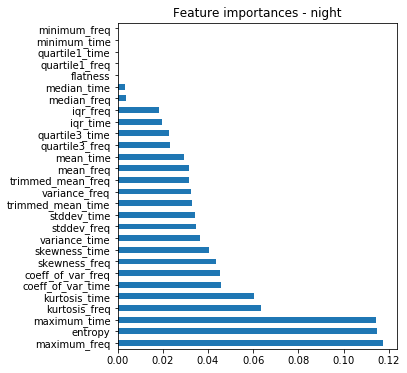

In [55]:
df = pd.Series(importances["night"], index=X_night.columns)
plt.figure(figsize=(5, 6))
df.nlargest(len(X_night.columns)).plot(kind="barh")
plt.title("Feature importances - night")
plt.show()

We have quite a few features here that performed really bad:
- `minimum_time`, `minimum_freq` - makes sense, it probably often be 0, when people sleep
- 1st quartile features - at night mostly flat activity curves are expected for both groupes
- `flatness` - I currently have no special explanation for this
- `median_time`, `median_freq` - most common value will probably be just 0 or near zero, just like with the minimum

There are also features that performed really well:
- `entropy` - perhaps connected to peaks in activity?
- `maximum_time`, `maximum_freq` - signifies whether someone had peaks of activity or not (normal, non-depressed people should just sleep)
- `kurtosis_time`, `kurtosis_freq` - maybe the depressed patients have more heavy-tailed distributions, e.g. phases with high activity and with next to none activity

It should be noted that often features for both time and frequency domain have similar importance. It may be worth checking if unifying the features, e.g. adding entropy to the time domain would improve performance.

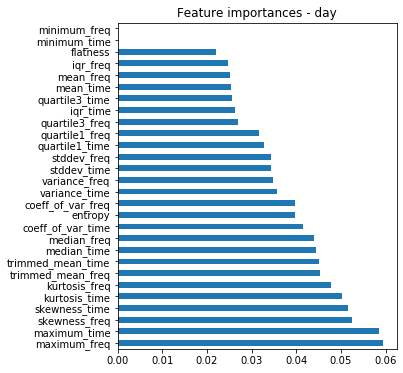

In [56]:
df = pd.Series(importances["day"], index=X_day.columns)
plt.figure(figsize=(5, 6))
df.nlargest(len(X_day.columns)).plot(kind="barh")
plt.title("Feature importances - day")
plt.show()

Situation during the day is much less clear, which is similar to the conclusion from the paper.

The worst features are still minima in both domain, and flatness is next least important one, but is much more relevant than is was during the night.

The best features are:
- `maximum_time`, `maximum_freq` - makes sense and may show that the depressed patients are not only less active on average, but even taking into account activity peaks
- `skewness_time`, `skewness_freq` - tail of the distribution is shown to be important, also adding the skewness to the time domain turns out to be highly beneficial
- `kurtosis_time`, `kurtosis_freq` - even more features describing the overall shape of the distribution; it's clear that condition and control groups form vastly different activity distributions

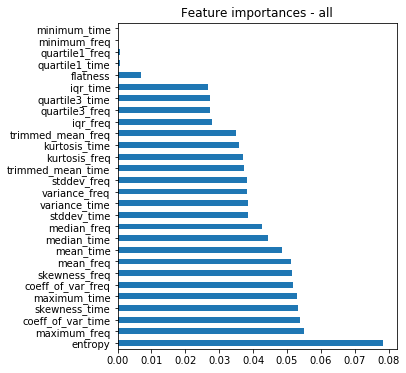

In [57]:
df = pd.Series(importances["all"], index=X_all.columns)
plt.figure(figsize=(5, 6))
df.nlargest(len(X_all.columns)).plot(kind="barh")
plt.title("Feature importances - all")
plt.show()

When taking into account all features, the situation is a mix of night and day conclusions. The worst features are just like in the night data, while the overall importances (quite high for many features) are similar to the results for day data. 

Best feature is by far `entropy`, which is calculated only in the frequency domain. With such a high dominance it will be definitely worth checking how will it perform when calculated also for the time domain.

## Testing approach

With only 55 samples and class imbalance (only 23 samples in the condition group) I've decided to not use test set and rely on 4-fold cross validation. While this may definitely be a controversial decision, I believe that with such a low number of samples and relatively high number of features it has to be done. The test set of reasonable size (leaving enough samples for training and validation) would be only 3-4 samples from condition and control groups anyway, which is not large enough to be a reasonable approximation of the generalization error.

In [58]:
from sklearn.model_selection import cross_val_score

In [59]:
def get_cv_raport(cv_results: np.ndarray) -> None:
    result = f"accuracy: {cv_results.mean():.2f} ± {np.std(cv_results):.2f}, "
    result += f"min: {cv_results.min():.2f}, "
    result += f"max: {cv_results.max():.2f}"
    return result

## Random Forest classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight="balanced", random_state=0)
cv_scores = cross_val_score(clf, X_night, y, scoring="accuracy", cv=3, n_jobs=-1)

In [62]:
print(get_cv_raport(cv_scores))

accuracy: 0.95 ± 0.00, min: 0.94, max: 0.95
